In [1]:
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

## Goal: Generate survival curves for patient level data for genes

Steps

survival analysis as specified in this project plan https://docs.google.com/document/d/1m4oHf4mL8xrwRjJbfZEe02NuO8qJH8iIC7nJ9f8qKpY/edit

## Outputs
* survival plots for each gene for 4 different groups (90/90), (90/10), (75/75). (75/25)
* dataframe/csv of log rank p values for all genes and all groups

In [24]:
gene_list_csv = '../data/FDA Target List Pre-SNRNA.csv'
gene_list_name = 'fda'
cohort = 'tcga'

In [3]:
genes_to_keep = pd.read_csv(gene_list_csv, header = None)
genes_to_keep = list(genes_to_keep[0])

In [4]:
gene_file = 'bulkky.csv'
survival_file = 'survival.csv'
data_dir = '../data'

In [5]:
df_gene = pd.read_csv(os.path.join(data_dir,gene_file),index_col = False)
df_survival = pd.read_csv(os.path.join(data_dir,survival_file))
df_gene.head()

,Unnamed: 0,tcga-2j-aab1-0,tcga-2j-aab4-0,tcga-2j-aab8-0,tcga-2j-aabe-0,tcga-2j-aabh-0,tcga-2j-aabk-0,tcga-2j-aabo-0,tcga-2j-aabp-0,tcga-2j-aabt-0,...,PCSI_0048-2,PCSI_0460-2,PCSI_0301-2,PCSI_0074-2,PCSI_0230-2,PCSI_0593-2,PCSI_0642-2,PCSI_0173-2,PCSI_0162-2,PCSI_0638-2
0,FGFR2,3.321870,3.555205,3.198075,3.325090,2.157619,3.410962,2.305467,1.593193,3.818382,...,3.956832,2.718442,3.091814,4.486808,3.855023,3.941427,3.361588,2.241948,2.462543,2.503070
1,SFT2D3,2.554821,2.141104,2.694381,2.594298,2.328804,2.309437,2.635775,2.550215,2.098051,...,0.010256,0.037203,0.056899,0.073533,0.016807,0.065275,0.027492,0.000000,2.385753,0.000000
2,CLEC2L,0.114166,0.268167,0.126541,0.264928,0.360577,0.251321,0.977498,1.972221,0.367716,...,0.000000,0.000000,0.111527,0.000000,0.000000,0.000000,0.000000,0.268521,0.000000,0.000000
3,PCYT2,3.828386,3.381373,3.316260,3.402833,3.877422,3.139071,3.676570,3.099575,3.483028,...,2.406003,2.808628,3.102525,3.961894,4.001701,4.375243,3.841514,4.545875,4.427328,3.890691
4,ZNF630,1.163930,1.074284,1.195381,1.124767,0.919313,1.013129,1.142824,0.650426,1.040603,...,1.290594,0.558158,1.885497,1.949062,2.095290,0.675230,1.306497,0.647626,0.784424,1.808027


In [6]:
df_gene.shape

(17040, 309)

In [7]:
df_gene = df_gene.rename({'Unnamed: 0':'Gene'},axis = 1)
df_gene = df_gene.set_index(keys = ['Gene'])

In [8]:
df_gene_transposed = df_gene.T
df_gene_transposed.reset_index(inplace = True)
df_gene_transposed.rename({'index':'ID'}, inplace=True, axis = 1)

In [9]:
genes_to_keep = [gene for gene in genes_to_keep if gene in df_gene_transposed.columns]

In [10]:
df_gene_transposed = df_gene_transposed[['ID'] +genes_to_keep]

## Visualize distribution of genes

In [11]:
df_gene_transposed.head()

Gene,ID,IFNAR2,FYN,EPHB4,EPHA2,SCNN1A,GABRE,SRC,CD52,GABBR1,...,COMT,FKBP1A,TGFB1,FXYD2,SCTR,HDAC6,SLC25A4,GSR,TGFB3,MTOR
0,tcga-2j-aab1-0,3.277973,3.329232,4.093152,4.620841,5.462687,1.708810,4.149340,4.555192,1.948773,...,4.669536,5.495256,4.401959,5.286689,2.929559,3.220029,3.457950,3.625588,3.320230,2.389547
1,tcga-2j-aab4-0,3.641899,3.211832,3.812538,4.821477,4.806117,2.058621,4.314203,4.624192,2.524885,...,4.454937,5.436250,3.955498,6.285748,4.571290,3.464132,3.719290,3.589319,2.909249,2.857057
2,tcga-2j-aab8-0,3.150072,3.520200,3.607117,4.455599,4.441562,2.428726,3.750309,4.527676,3.056915,...,4.374988,5.704782,4.067659,1.658927,1.587801,3.457996,3.009131,3.322276,4.184838,2.987935
3,tcga-2j-aabe-0,3.508511,3.671988,4.103720,4.630403,4.876857,3.259676,4.114091,4.886573,3.261645,...,4.732883,5.552592,4.540932,4.902380,3.592114,3.470647,3.815874,3.205986,3.575719,3.032473
4,tcga-2j-aabh-0,3.514687,2.881983,3.805339,4.253487,4.871977,2.117369,4.308600,3.935183,2.278915,...,3.662019,5.068076,4.012066,5.260367,3.876785,3.383435,3.250126,3.719043,3.153773,2.436839


In [12]:
#plt.figure(figsize = (30,15))
#sns.heatmap(df_gene_transposed.drop(['ID'],axis = 1),cmap="YlGnBu")

In [13]:
df_gene_transposed.shape

(308, 60)

In [14]:
gene_column_list = [col for col in list(df_gene_transposed.columns) if 'ID' not in col]

In [15]:
df_survival.shape

(309, 5)

In [16]:
df_survival.head()

,pid,OS,OS_status,PFS,PFS_status
0,tcga-2j-aab1-0,2.169839,1.0,2.169839,0.0
1,tcga-2j-aab4-0,23.966861,0.0,23.966861,0.0
2,tcga-2j-aab8-0,2.630108,0.0,2.630108,0.0
3,tcga-2j-aabe-0,22.224414,0.0,22.224414,0.0
4,tcga-2j-aabk-0,15.912154,0.0,15.912154,0.0


## merge datasets

In [17]:
df_joined = pd.merge(df_gene_transposed, df_survival, left_on = ['ID'], right_on = ['pid'], how = 'inner')

In [18]:
df_joined.shape

(307, 65)

In [19]:
df_joined = df_joined[df_joined['ID'].str.contains('tcga')]
df_joined.shape

(139, 65)

## visualize missing data

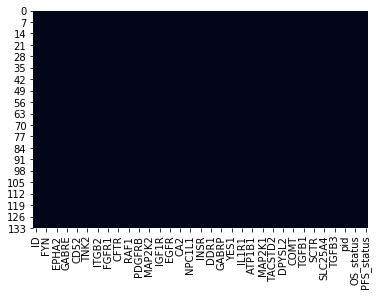

In [20]:
sns.heatmap(df_joined.isnull(), cbar = False)

In [21]:
percentile_list = [
    (50,50),
    (25, 75),
    (10, 90),
    (75, 75),
    (90, 90)
]

gene_list = []
high_list = []
low_list = []
p_list = []
count_high_list = []
count_low_list = []
value_high_list = []
value_low_list = []
longer_survival_list = []

for idx, gene in enumerate(gene_column_list):
    df_gene = df_joined[[gene,'OS', 'OS_status']]

    for percentile_low, percentile_high in percentile_list:
        
        value_high = np.percentile(df_gene[gene], percentile_high)
        value_low = np.percentile(df_gene[gene], percentile_low)
        
        df_high = df_gene[df_gene[gene] > value_high]
        df_low = df_gene[df_gene[gene] <= value_low]
        
        mean_high = df_high['OS'].mean()
        mean_low = df_low['OS'].mean()
        
        if mean_high > mean_low:
            longer_survival = 'above'
        else:
            longer_survival = 'below'

        duration_high = df_high['OS']
        duration_low = df_low['OS']
        
        observed_high = df_high['OS_status'].astype(int)
        observed_low = df_low['OS_status'].astype(int)
        
        res = logrank_test(duration_high,duration_low, observed_high, observed_low)
        p_value = res.p_value
        
        gene_list.append(gene)
        high_list.append(percentile_high)
        low_list.append(percentile_low)
        p_list.append(p_value)
        count_high_list.append(df_high.shape[0])
        count_low_list.append(df_low.shape[0])
        value_high_list.append(value_high)
        value_low_list.append(value_low)
        longer_survival_list.append(longer_survival)
        
        if p_value < .05:
            plt.figure()
            ax = plt.subplot(111)
            kmf = KaplanMeierFitter()
            kmf.fit(duration_high, observed_high, label="Above {:.0f} percentile".format(percentile_high))
            ax = kmf.plot(ax=ax)

            kmf.fit(duration_low, observed_low,label="Below {:.0f} percentile".format(percentile_low))
            ax = kmf.plot(ax=ax)

            ax.set_title("Kaplan Meier Curve - {}".format(gene));
            ax.set_ylabel('survival')
            plt.savefig('outputs/survival_plots_{}_{}/{}_{}_high_{}_low.png'.format(gene_list_name,
                                                                                    cohort,
                                                                                    gene,
                                                                                    percentile_high,
                                                                                    percentile_low))
            plt.close()
        
        print('done with {}/{}'.format(idx+1, len(gene_column_list)))

done with 1/59
done with 1/59
done with 1/59
done with 1/59
done with 1/59
done with 2/59
done with 2/59
done with 2/59
done with 2/59
done with 2/59
done with 3/59
done with 3/59
done with 3/59
done with 3/59
done with 3/59
done with 4/59
done with 4/59
done with 4/59
done with 4/59
done with 4/59
done with 5/59
done with 5/59
done with 5/59
done with 5/59
done with 5/59
done with 6/59
done with 6/59
done with 6/59
done with 6/59
done with 6/59
done with 7/59
done with 7/59
done with 7/59
done with 7/59
done with 7/59
done with 8/59
done with 8/59
done with 8/59
done with 8/59
done with 8/59
done with 9/59
done with 9/59
done with 9/59
done with 9/59
done with 9/59
done with 10/59
done with 10/59
done with 10/59
done with 10/59
done with 10/59
done with 11/59
done with 11/59
done with 11/59
done with 11/59
done with 11/59
done with 12/59
done with 12/59
done with 12/59
done with 12/59
done with 12/59
done with 13/59
done with 13/59
done with 13/59
done with 13/59
done with 13/59
done 

In [22]:
output_df = pd.DataFrame(
{'gene': gene_list,
'above_percentile': high_list,
'below_percentile':low_list,
'p_value': np.round(p_list,4),
'count_above': count_high_list,
'count_below': count_low_list,
'above_percentile_value': np.round(value_high_list,4),
'below_percentile_value': np.round(value_low_list,4),
'longer_survival':longer_survival_list
}
)

In [23]:
output_df.to_csv('outputs/logrank_results_{}_{}.csv'.format(gene_list_name,cohort),index=False)